In [143]:
import pandas as pd

In [144]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [145]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [146]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [147]:
len(data)

7043

In [148]:
# import numpy as np
# data['null_col'] = np.nan

In [149]:
data.isnull().sum() * 100 / len(data)

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [122]:
from sklearn import preprocessing
import pandas as pd
from sklearn import linear_model


class CategoricalFeatures:
    def __init__(self, df, categorical_features, encoding_type, handle_na=False):
        """
        df: pandas dataframe
        categorical_features: list of column names, e.g. ["ord_1", "nom_0"......]
        encoding_type: label, binary, ohe
        handle_na: True/False
        """
        self.df = df
        self.cat_feats = categorical_features
        self.enc_type = encoding_type
        self.handle_na = handle_na
        self.label_encoders = dict()
        self.binary_encoders = dict()
        self.ohe = None

        if self.handle_na:
            for c in self.cat_feats:
                self.df.loc[:, c] = self.df.loc[:, c].astype(str).fillna("-9999999")
        self.output_df = self.df.copy(deep=True)
    
    def _label_encoding(self):
        for c in self.cat_feats:
            lbl = preprocessing.LabelEncoder()
            lbl.fit(self.df[c].values)
            self.output_df.loc[:, c] = lbl.transform(self.df[c].values)
            self.label_encoders[c] = lbl
        return self.output_df
    
    def _label_binarization(self):
        for c in self.cat_feats:
            lbl = preprocessing.LabelBinarizer()
            lbl.fit(self.df[c].values)
            val = lbl.transform(self.df[c].values)
            self.output_df = self.output_df.drop(c, axis=1)
            for j in range(val.shape[1]):
                new_col_name = c + f"__bin_{j}"
                self.output_df[new_col_name] = val[:, j]
            self.binary_encoders[c] = lbl
        return self.output_df

    def _one_hot(self):
        ohe = preprocessing.OneHotEncoder()
        ohe.fit(self.df[self.cat_feats].values)
        return ohe.transform(self.df[self.cat_feats].values)

    def fit_transform(self):
        if self.enc_type == "label":
            return self._label_encoding()
        elif self.enc_type == "binary":
            return self._label_binarization()
        elif self.enc_type == "ohe":
            return self._one_hot()
        else:
            raise Exception("Encoding type not understood")
    
    def transform(self, dataframe):
        if self.handle_na:
            for c in self.cat_feats:
                dataframe.loc[:, c] = dataframe.loc[:, c].astype(str).fillna("-9999999")

        if self.enc_type == "label":
            for c, lbl in self.label_encoders.items():
                dataframe.loc[:, c] = lbl.transform(dataframe[c].values)
            return dataframe

        elif self.enc_type == "binary":
            for c, lbl in self.binary_encoders.items():
                val = lbl.transform(dataframe[c].values)
                dataframe = dataframe.drop(c, axis=1)
                
                for j in range(val.shape[1]):
                    new_col_name = c + f"__bin_{j}"
                    dataframe[new_col_name] = val[:, j]
            return dataframe

        elif self.enc_type == "ohe":
            return self.ohe(dataframe[self.cat_feats].values)
        
        else:
            raise Exception("Encoding type not understood")

In [123]:
id_col = ""
target_col = "Churn"
def find_id_column(data):
    for i in data.columns:
        # find unique id column
        try:
            col_unique_len = len(data[i].unique())
            if col_unique_len == len(data):
                print("Found id column '{0}'".format(i))
                return str(i)
        except Exception as e:
            pass
id_col = find_id_column(data)

Found id column 'customerID'


In [138]:
def split_cols_by_types(data):
    try:
        float_columns=[]
        cat_columns=[]
        int_columns=[]
        for i in data.columns:
            if "float" in str(data[i].dtype): 
                float_columns.append(i)
            elif "int" in str(data[i].dtype):
                int_columns.append(i)
            elif "object" in str(data[i].dtype):
                cat_columns.append(i)
        return cat_columns,float_columns,int_columns
    except Exception as e:
        print(e)
        pass

In [139]:
cat_columns, float_columns, int_columns = split_cols_by_types(data)

In [140]:
print(cat_columns)
print(float_columns)
print(int_columns)

['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']
['MonthlyCharges']
['SeniorCitizen', 'tenure']


In [142]:
data_cat_features = data[cat_columns]
data_float_features = data[float_columns]
data_int_features = data[int_columns]

In [106]:
cat_col = [c for c in data.columns if c not in [id_col, target_col]]
cat_feats = CategoricalFeatures(data_cat_features, 
                                categorical_features=cat_columns, 
                                encoding_type="label",
                                handle_na=True)
cat_data_transformed = cat_feats.fit_transform()

In [107]:
# def data_preprocessing(data):
    
#     for i in data.columns:
#         # Drop unique id column
#         try:
#             col_unique_len = len(data[i].unique())
#             if col_unique_len == len(data):
#                 print("Dropping id column '{0}'".format(i))
#                 data = data.drop([i],axis=1)
#         except Exception as e:
#             continue
            
#         # Drop column with nearly 70% null values  
#         try:
#             col_null_per = int(data[i].isnull().sum() * 100 / len(data))
#             if col_null_per > 70:
#                 print("Dropping column '{}' with more than 70% null values.".format(i))
#                 data = data.drop([i],axis=1)
#         except Exception as e:
#             continue
            
#     return data
        

In [108]:
# data = data_preprocessing(data)

In [109]:
data_len = len(data)
train_len = round(data_len * 0.8)

In [110]:
train_len

5634

In [112]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.1,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.8,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [111]:
full_data_transformed

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,446,2505,No
1,5575-GNVDE,1,0,0,0,28,1,0,0,2,...,2,0,0,0,1,0,3,802,1466,No
2,3668-QPYBK,1,0,0,0,12,1,0,0,2,...,0,0,0,0,0,1,3,740,157,Yes
3,7795-CFOCW,1,0,0,0,40,0,1,0,2,...,2,2,0,0,1,0,0,570,1400,No
4,9237-HQITU,0,0,0,0,12,1,0,1,0,...,0,0,0,0,0,1,2,1033,925,Yes
5,9305-CDSKC,0,0,0,0,71,1,2,1,0,...,2,0,2,2,0,1,2,1578,6104,Yes
6,1452-KIOVK,1,0,0,1,15,1,2,1,0,...,0,0,2,0,0,1,1,1379,1550,No
7,6713-OKOMC,0,0,0,0,2,0,1,0,2,...,0,0,0,0,0,0,3,444,2609,No
8,7892-POOKP,0,0,1,0,21,1,2,1,0,...,2,2,2,2,0,1,2,90,2646,Yes
9,6388-TABGU,1,0,0,1,59,1,0,0,2,...,0,0,0,0,1,0,0,786,3022,No


In [101]:
X = full_data_transformed[:train_len, :]
X_test = full_data_transformed[train_len:, :]

In [105]:
clf = linear_model.LogisticRegression()
clf.fit(X, data.target_col.values)
preds = clf.predict_proba(X_test)[:, 1]

ValueError: Found input variables with inconsistent numbers of samples: [5634, 7043]

In [97]:
# data = data.drop(['customerID'],axis=1)

In [98]:
# data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [99]:
# len(data.columns)

20

In [100]:
# import missingno as msno
# %matplotlib inline

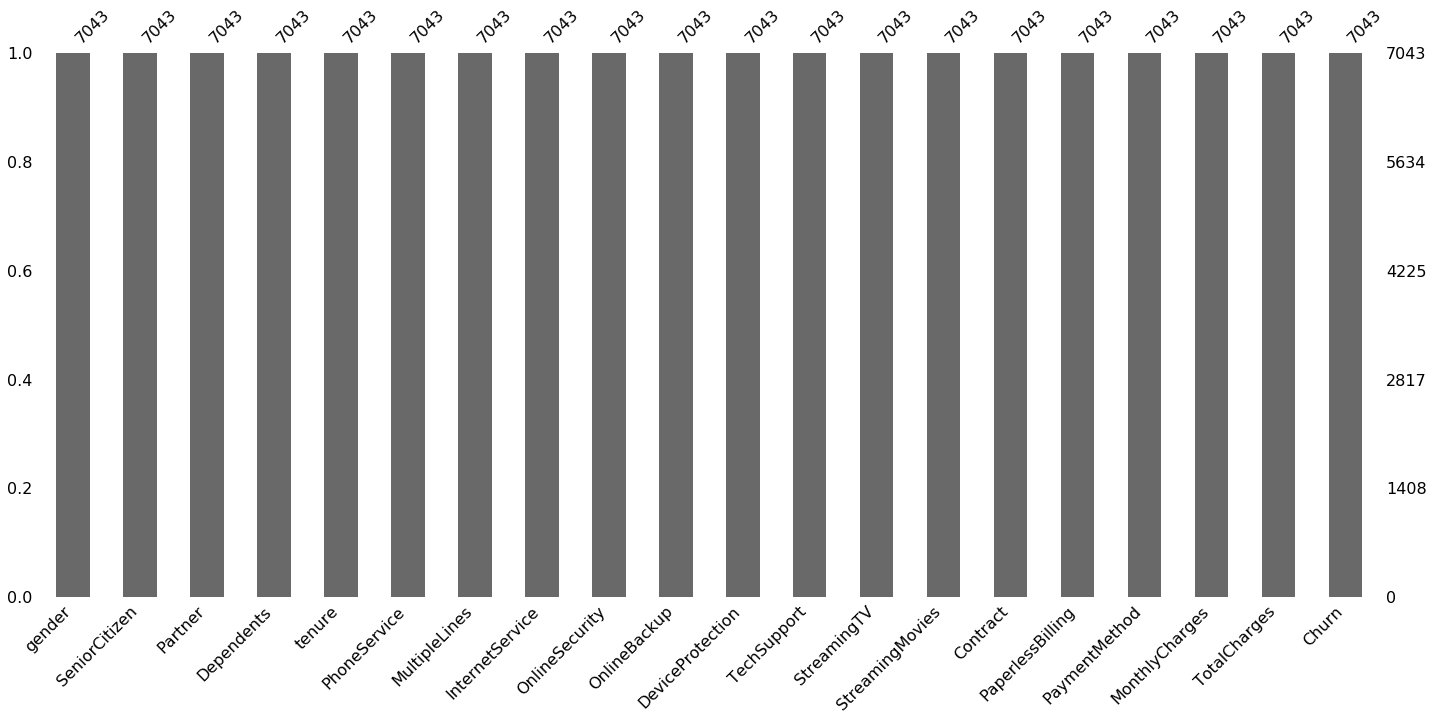

In [101]:
# msno.bar(data)

In [102]:
# for i in data.columns:
#     print(i + " --> " + str(data[i].unique()))

gender --> ['Female' 'Male']
SeniorCitizen --> [0 1]
Partner --> ['Yes' 'No']
Dependents --> ['No' 'Yes']
tenure --> [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService --> ['No' 'Yes']
MultipleLines --> ['No phone service' 'No' 'Yes']
InternetService --> ['DSL' 'Fiber optic' 'No']
OnlineSecurity --> ['No' 'Yes' 'No internet service']
OnlineBackup --> ['Yes' 'No' 'No internet service']
DeviceProtection --> ['No' 'Yes' 'No internet service']
TechSupport --> ['No' 'Yes' 'No internet service']
StreamingTV --> ['No' 'Yes' 'No internet service']
StreamingMovies --> ['No' 'Yes' 'No internet service']
Contract --> ['Month-to-month' 'One year' 'Two year']
PaperlessBilling --> ['Yes' 'No']
PaymentMethod --> ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges -

In [103]:
cat_feature_names = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService',\
               'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract',\
               'PaperlessBilling','PaymentMethod']
num_feature_names = ['tenure','MonthlyCharges','TotalCharges']

In [104]:
categorical_features = [0,1,2,3,5,6,7,8,9,10,11,12,13,14,15]
numerical_featues = [4,16,17]

In [105]:
import sklearn

In [106]:
labels = data.iloc[:,19]
le= sklearn.preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
data = data.iloc[:,:-1]

In [107]:
class_names

array(['No', 'Yes'], dtype=object)

In [108]:
labels

array([0, 0, 1, ..., 0, 1, 0])

In [109]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


In [110]:
categorical_names = {}
for feature in categorical_features:
#     print(feature)
    le = preprocessing.LabelEncoder()
    le.fit(data.iloc[:, feature])
    data[feature] = le.transform(data.iloc[:, feature])
    categorical_names[feature] = le.classes_

In [111]:
categorical_names

{0: array(['Female', 'Male'], dtype=object),
 1: array([0, 1], dtype=int64),
 2: array(['No', 'Yes'], dtype=object),
 3: array(['No', 'Yes'], dtype=object),
 5: array(['No', 'Yes'], dtype=object),
 6: array(['No', 'No phone service', 'Yes'], dtype=object),
 7: array(['DSL', 'Fiber optic', 'No'], dtype=object),
 8: array(['No', 'No internet service', 'Yes'], dtype=object),
 9: array(['No', 'No internet service', 'Yes'], dtype=object),
 10: array(['No', 'No internet service', 'Yes'], dtype=object),
 11: array(['No', 'No internet service', 'Yes'], dtype=object),
 12: array(['No', 'No internet service', 'Yes'], dtype=object),
 13: array(['No', 'No internet service', 'Yes'], dtype=object),
 14: array(['Month-to-month', 'One year', 'Two year'], dtype=object),
 15: array(['No', 'Yes'], dtype=object)}

In [112]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,6,7,8,9,10,11,12,13,14,15
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,1,0,0,2,0,0,0,0,0,1
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,0,0,2,0,2,0,0,0,1,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,0,0,2,2,0,0,0,0,0,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,1,0,2,0,2,2,0,0,1,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,0,1,0,0,0,0,0,0,0,1
